<a href="https://colab.research.google.com/github/oThiagoBittencourt/ObesityClusteringAI/blob/main/ObesidadeCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Normalização da base de dados**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [6]:
# NORMALIZAR OS DADOS
dados = pd.read_csv('/content/drive/MyDrive/IA/ObesidadeProjeto/ObesityDataSet_raw_and_data_sinthetic.csv', sep=',')
dados.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
# DIVISÃO DE DADOS
dados_numericos = dados.drop(columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])
dados_categoricos = dados[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']]

# NORMALIZAÇÃO DADOS CATEGÓRICOS
dados_categoricos_normalizados = pd.get_dummies(data=dados_categoricos,prefix_sep='_', dtype=int)
print(dados_categoricos_normalizados)

# NORMALIZAÇÃO DADOS NUMÉRICOS
from sklearn import preprocessing
normalizador = preprocessing.MinMaxScaler()
modelo_normalizador = normalizador.fit(dados_numericos)
from pickle import dump
dump(modelo_normalizador, open('/content/drive/MyDrive/IA/ObesidadeProjeto/normalizadorObesidade.pkl', 'wb'))

In [ ]:
# NORMALIZAR A BASE DE DADOS DE ENTRADA
dados_numericos_normalizados = modelo_normalizador.fit_transform(dados_numericos)

# CONVERTER OS DADOS NUMERICOS NORMALIZADOS EM DATA FRAME
dados_numericos_normalizados = pd.DataFrame(data = dados_numericos_normalizados, columns=['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])
print(dados_numericos_normalizados)

# CRIAR UM DATAFRAME COM OS DADOS NORMALIZADOS (CATEGÓRICOS E NUMÉRICOS)
dados_normalizados_final = dados_numericos_normalizados.join(dados_categoricos_normalizados, how='left')
print(dados_normalizados_final.head(10))

# **Determinação do número ideal de clusters**

In [ ]:
# Determinar o numero ótimo de clusters pela distorção
from sklearn.cluster import KMeans        # Clusterizador
import matplotlib.pyplot as plt           # Para gráficos
import math                               # Matemática
from scipy.spatial.distance import cdist  # Calcular as distancias e distorções
import numpy as np                        # Para procedimentos numéricos
distortions = []
K = range(1,101)

# Treinar iterativamente conforme n_cluster = K[i]
for k in K:
  obesidade_kmeans_model = KMeans(n_clusters = k).fit(dados_normalizados_final)
  distortions.append(sum(np.min(cdist(dados_normalizados_final,obesidade_kmeans_model.cluster_centers_,'euclidean'), axis=1) /dados_normalizados_final.shape[0]))
print(distortions)

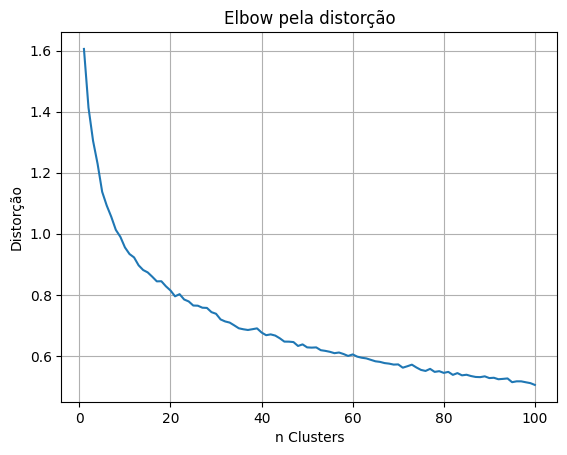

In [16]:
# Exibir o gráfico das distorções
fig, ax = plt.subplots()
ax.plot(K,distortions)
ax.set(xlabel = 'n Clusters', ylabel = 'Distorção', title = 'Elbow pela distorção')
ax.grid()
fig.savefig('elbow_distorcao.png')
plt.show()

In [17]:
# Calcular o número ótimo de clusters
x0 = K[0]
y0 = distortions[0]
xn = K[len(K) -1]
yn = distortions[len(distortions)-1]

# Iterar nos pontos gerados durante os treinamentos preliminares
distancias = []
for i in range(len(distortions)):
    x = K[i]
    y = distortions[i]
    numerador = abs((yn-y0) * x - (xn-x0) * y + xn * y0 - yn * x0)
    denominador = math.sqrt((yn-y0)**2 + (xn - x0)**2)
    distancias.append(numerador/denominador)

# Maior distância
# K[distancias.index(np.max(distancias))] # Hiperparatremização simplificada por biblioteca
n_clusters_otimos = K[distancias.index(np.max(distancias))]
print(n_clusters_otimos)

21


# **Treinamento**

In [18]:
# Treinar o modelo definitivo
obesidade_kmeans_model = KMeans(n_clusters = n_clusters_otimos, random_state=42).fit(dados_normalizados_final)

# Treinar o modelo definitivo
dump(obesidade_kmeans_model, open('/content/drive/MyDrive/IA/ObesidadeProjeto/obesidade_clusters_2024.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
